# Importamos las librerias

In [1]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_validate, StratifiedKFold
from missforest import MissForest
from sklearn.ensemble import IsolationForest, RandomForestRegressor, VotingRegressor, StackingRegressor, RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform, chi2_contingency
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.svm import SVR
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


# Importamos el DataFrame

In [2]:
df = pd.read_csv(r"/workspaces/carlos060495-intro-ml/data/raw/bank-marketing-campaign-data.csv", sep=";")
pd.set_option('display.max_columns', None)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

# 1.1 Identificar y eliminar columnas con valores contantes

In [4]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
0
1
2
3
4
...
41183
41184
41185
41186


# 1.2 Eliminamos filas y columnas duplicadas

In [5]:
df.duplicated().sum()

np.int64(12)

In [6]:
df.T.duplicated().sum()

np.int64(0)

In [7]:
df.T.duplicated(keep=False)

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

# 1.3 Eliminar columnas redundantes

In [8]:
# Codificar y como binaria
df['y_bin'] = df['y'].map({'yes': 1, 'no': 0})

# Selección de columnas numéricas
num_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

# Correlación con y_bin
correlations = df[num_cols].corrwith(df['y_bin']).sort_values(ascending=False)
print(correlations)
print()

cat_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'poutcome'
]

results = []
for col in cat_cols:
    table = pd.crosstab(df[col], df['y'])
    chi2, _, _, _ = chi2_contingency(table)
    n = table.values.sum()
    r, k = table.shape
    v = np.sqrt(chi2 / (n * (min(r-1, k-1))))
    results.append((col, v))

# Mostrar ordenado por fuerza de asociación
assoc_df = pd.DataFrame(results, columns=['Variable', 'Cramers_V']).sort_values('Cramers_V', ascending=False)
print(assoc_df)



duration          0.405274
previous          0.230181
cons.conf.idx     0.054878
age               0.030399
campaign         -0.066357
cons.price.idx   -0.136211
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354678
dtype: float64

      Variable  Cramers_V
9     poutcome   0.320488
7        month   0.274395
0          job   0.152768
6      contact   0.144693
3      default   0.099354
2    education   0.068472
1      marital   0.054570
8  day_of_week   0.025195
4      housing   0.011748
5         loan   0.005154


Se eliminan las columnas 'day_of_week', 'housing' y 'loan' porque muestran una asociación casi nula con la variable objetivo y no aportan información relevante ni diferenciada respecto a otras variables del dataset, y su inclusión solo añadiría ruido al modelo.

In [9]:
df = df.drop(['day_of_week', 'housing', 'loan'], axis=1)
df

,age,job,marital,education,default,contact,month,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_bin
0,56,housemaid,married,basic.4y,no,telephone,may,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,telephone,may,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,telephone,may,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,telephone,may,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,telephone,may,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,cellular,nov,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41184,46,blue-collar,married,professional.course,no,cellular,nov,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41185,56,retired,married,university.degree,no,cellular,nov,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41186,44,technician,married,professional.course,no,cellular,nov,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1


# 1.4 Eliminar columnas Data leakage

La columna 'duration' se elimina porque su valor solo se conoce después de la interacción con el cliente, lo que introduce data leakage; en otras palabras, el modelo estaría aprendiendo de un dato que depende directamente del resultado de la llamada, generando un entrenamiento poco realista y un desempeño engañoso en producción.


In [10]:
df = df.drop(['duration'], axis=1)
df


,age,job,marital,education,default,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_bin
0,56,housemaid,married,basic.4y,no,telephone,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,telephone,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,telephone,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,telephone,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,telephone,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,cellular,nov,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41184,46,blue-collar,married,professional.course,no,cellular,nov,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41185,56,retired,married,university.degree,no,cellular,nov,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41186,44,technician,married,professional.course,no,cellular,nov,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1


# 1.5 Valores faltantes

In [11]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

Series([], dtype: float64)

In [12]:
df.isnull().any(axis=1).sum()

np.int64(0)

# 1.5.1 Realizamos una busqueda profunda de valores faltantes

In [13]:
# Recorro las columnas para realizar una busqueda por sus valores por si encontramos valores faltantes enmascarados
for columna in df.columns:
    print(df[columna].value_counts())

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
91       2
98       2
95       1
87       1
94       1
Name: count, Length: 78, dtype: int64
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
contact
cellular     26144
telephone    15044
Name: count, dtype: int64


In [14]:
# Encontramos valores como unknown y nonexistent en el dataframe y mostramos las columnas en las que existen
valores_a_filtrar = ['unknown', 'nonexistent']
mask_columnas = df.isin(valores_a_filtrar).any(axis=0)
df_filtrado = df.loc[:, mask_columnas]
print(df_filtrado)


               job  marital            education  default     poutcome
0        housemaid  married             basic.4y       no  nonexistent
1         services  married          high.school  unknown  nonexistent
2         services  married          high.school       no  nonexistent
3           admin.  married             basic.6y       no  nonexistent
4         services  married          high.school       no  nonexistent
...            ...      ...                  ...      ...          ...
41183      retired  married  professional.course       no  nonexistent
41184  blue-collar  married  professional.course       no  nonexistent
41185      retired  married    university.degree       no  nonexistent
41186   technician  married  professional.course       no  nonexistent
41187      retired  married  professional.course       no      failure

[41188 rows x 5 columns]


In [15]:
# Reemplazamos los valores faltantes enmascarados por valores nulos
df = df.replace(['unknown', 'nonexistent'], np.nan)
print(df)


       age          job  marital            education default    contact  \
0       56    housemaid  married             basic.4y      no  telephone   
1       57     services  married          high.school     NaN  telephone   
2       37     services  married          high.school      no  telephone   
3       40       admin.  married             basic.6y      no  telephone   
4       56     services  married          high.school      no  telephone   
...    ...          ...      ...                  ...     ...        ...   
41183   73      retired  married  professional.course      no   cellular   
41184   46  blue-collar  married  professional.course      no   cellular   
41185   56      retired  married    university.degree      no   cellular   
41186   44   technician  married  professional.course      no   cellular   
41187   74      retired  married  professional.course      no   cellular   

      month  campaign  pdays  previous poutcome  emp.var.rate  cons.price.idx  \
0     

In [16]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

job           0.801204
marital       0.194231
education     4.202680
default      20.872584
poutcome     86.343110
dtype: float64

<Axes: >

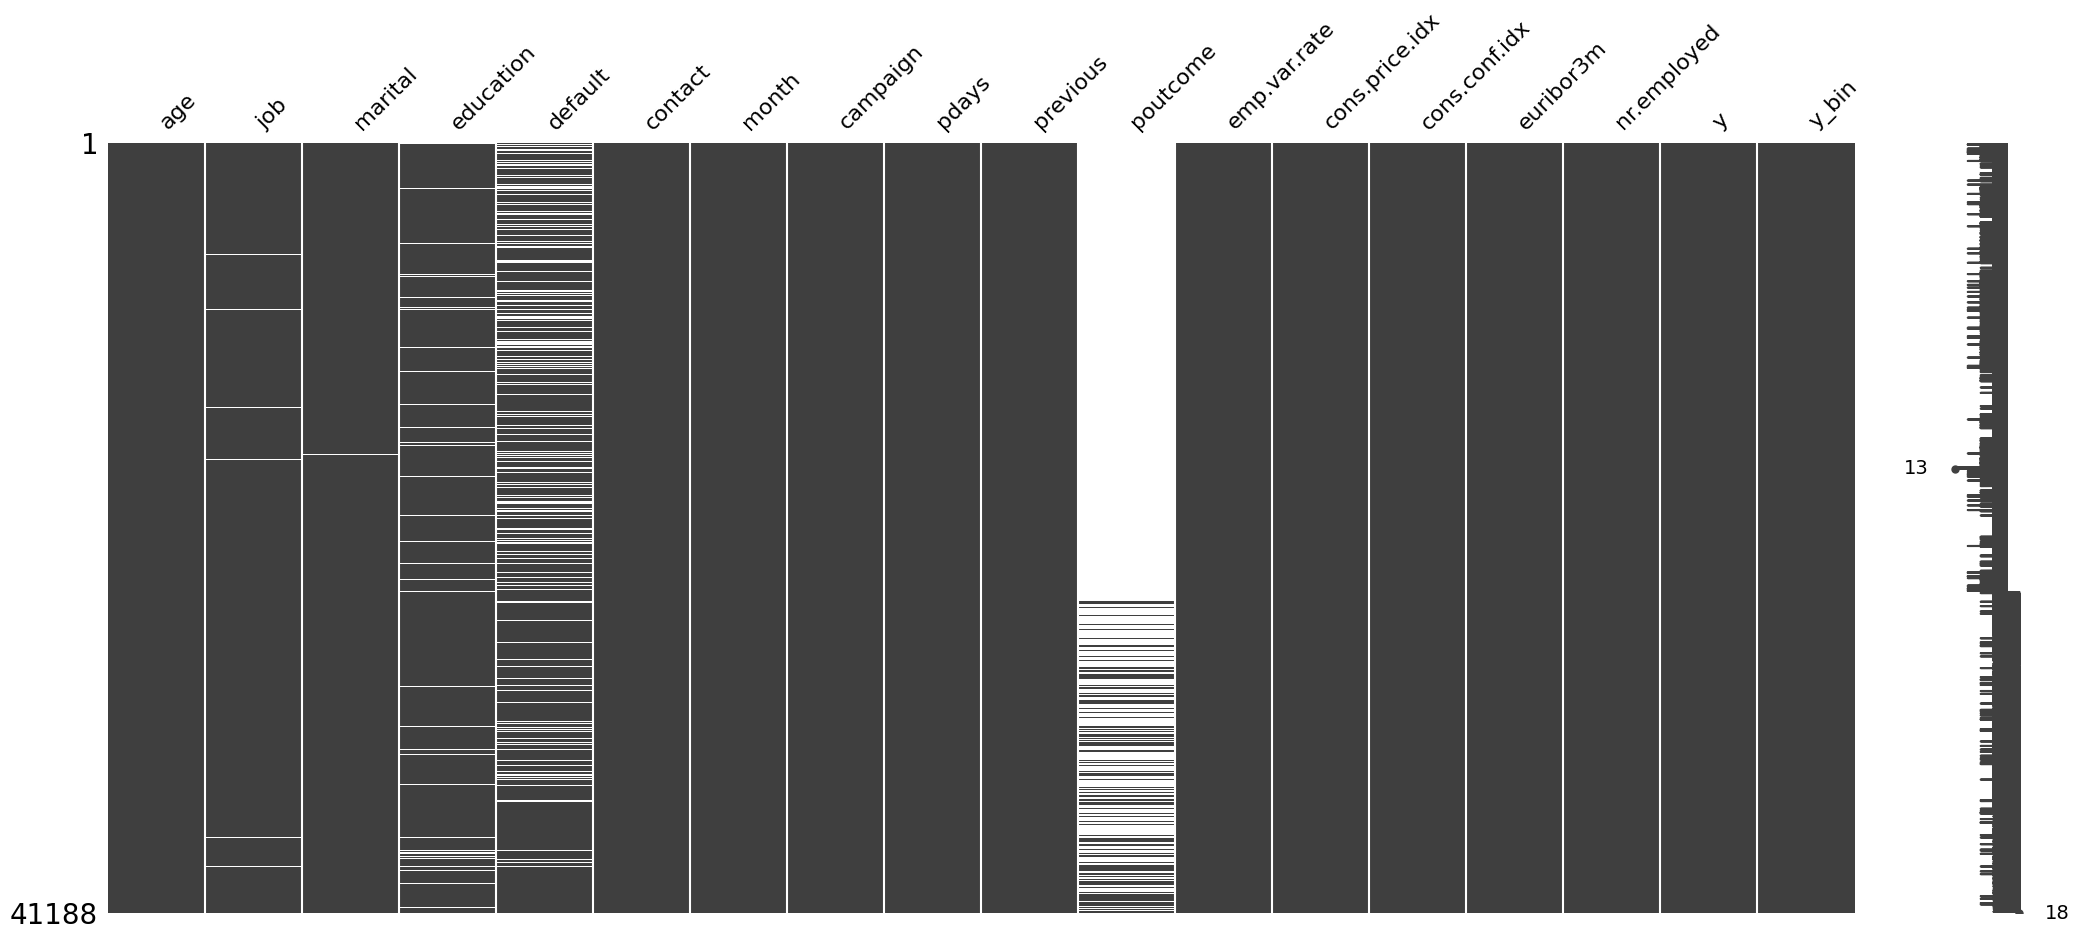

In [17]:
msno.matrix(df)

In [18]:
""" Eliminamos la columna poutcome por 2 razones, la primera es la cantidad de informacion faltante en esta columna y la segunda es que esta podria 
generar un problema de data leakage ya que este es un resultado obtenido despues de realizar la campaña, no es algo que se obtenga antes de la prediccion"""
df.drop("poutcome", axis=1, inplace=True)
df

,age,job,marital,education,default,contact,month,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_bin
0,56,housemaid,married,basic.4y,no,telephone,may,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,NaN,telephone,may,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,telephone,may,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,telephone,may,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,telephone,may,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,cellular,nov,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41184,46,blue-collar,married,professional.course,no,cellular,nov,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,no,0
41185,56,retired,married,university.degree,no,cellular,nov,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,no,0
41186,44,technician,married,professional.course,no,cellular,nov,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,yes,1


Mantenemos las demas columnas con valores nulos ya que tienen un porcentaje aceptable de datos nulos y podrian ser importantes para realizar la prediccion

# 2.1 Train test split

In [19]:
X = df.drop(['y', 'y_bin'], axis=1)
y = df['y_bin']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.2 Imputar

In [21]:
# Muestro las columnas con valores nulos para proceder a la imputacion de elementos
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

job           0.801204
marital       0.194231
education     4.202680
default      20.872584
dtype: float64

In [22]:
X_train[['job','marital','education','default']]

,job,marital,education,default
12556,blue-collar,married,basic.9y,NaN
35451,admin.,married,university.degree,no
30592,retired,married,basic.4y,no
17914,housemaid,divorced,basic.9y,no
3315,admin.,single,high.school,NaN
...,...,...,...,...
6265,retired,married,professional.course,NaN
11284,management,married,university.degree,no
38158,admin.,married,high.school,no
860,management,married,university.degree,no


In [23]:
X_train['job'].value_counts(normalize=True)*100

job
admin.           25.477239
blue-collar      22.757587
technician       16.372981
services          9.826236
management        7.066814
retired           4.169726
self-employed     3.527288
entrepreneur      3.502814
housemaid         2.652349
unemployed        2.441263
student           2.205702
Name: proportion, dtype: float64

In [24]:
X_train['marital'].value_counts(normalize=True)*100

marital
married     60.272432
single      28.377269
divorced    11.350299
Name: proportion, dtype: float64

In [25]:
X_train['education'].value_counts(normalize=True)*100

education
university.degree      30.902349
high.school            24.132357
basic.9y               15.238820
professional.course    13.235714
basic.4y               10.579696
basic.6y                5.869861
illiterate              0.041203
Name: proportion, dtype: float64

In [26]:
X_train['default'].value_counts(normalize=True)*100

default
no     99.988503
yes     0.011497
Name: proportion, dtype: float64

In [27]:
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
print(categorical_cols)

['job', 'marital', 'education', 'default', 'contact', 'month']


In [28]:
# Crear copia del DataFrame original
X_train_encoded = X_train.copy()

# Codificación binaria
X_train_encoded['default'] = X_train_encoded['default'].map({'yes': 1, 'no': 0})

# Codificación ordinal para educación
education_order = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6
}
X_train_encoded['education'] = X_train_encoded['education'].map(education_order)

# Codificación temporal para mes
month_order = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
X_train_encoded['month'] = X_train_encoded['month'].map(month_order)

# Codificación nominal automática
for col in ['job', 'marital', 'contact']:
        X_train_encoded[col] = X_train_encoded[col].astype('category').cat.codes


In [29]:
# Crear el imputador
imputer = MissForest(categorical=['job', 'marital', 'education', 'default', 'contact', 'month'])

# Aplicar la imputación
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

# Validación rápida
print("Nulos después de imputar:", X_train_imp.isnull().sum().sum())  # debería ser 0
print(X_train_imp.dtypes)  # todas las columnas deben ser numéricas


/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:13<00:00, 14.79s/it]
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00,  8.50it/s]

Nulos después de imputar: 0
age                 int64
job                  int8
marital              int8
education         float64
default           float64
contact              int8
month               int64
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object


In [30]:
X_train_imp.shape

(32950, 15)

# 3.1 Identificacion de Outliers

In [31]:
X_train_imp.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32950.0,40.017420,10.435842,17.000,32.000,38.000,47.000,98.000
job,32950.0,3.624917,3.555414,-1.000,0.000,2.000,7.000,10.000
marital,32950.0,1.166252,0.613447,-1.000,1.000,1.000,2.000,2.000
education,32950.0,4.142822,1.657508,0.000,3.000,4.000,6.000,6.000
default,32950.0,0.010561,0.102226,0.000,0.000,0.000,0.000,1.000
contact,32950.0,0.364765,0.481371,0.000,0.000,0.000,1.000,1.000
month,32950.0,6.615781,2.043398,3.000,5.000,6.000,8.000,12.000
campaign,32950.0,2.572959,2.778138,1.000,1.000,2.000,3.000,56.000
pdays,32950.0,962.745341,186.248245,0.000,999.000,999.000,999.000,999.000
previous,32950.0,0.172989,0.492992,0.000,0.000,0.000,0.000,7.000


In [32]:
iso = IsolationForest(random_state=123)
df_num = X_train_imp.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train_imp)

In [33]:
df_num['outlier_flag'].value_counts()

outlier_flag
 1    25941
-1     7009
Name: count, dtype: int64

# 4.1 Selección de características

## 4.1.1 Método 1: Feature importance de RF

In [34]:
model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train_imp, y_train)

In [35]:
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': X_train_imp.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()

In [36]:
df_rf_imp

,feature,rf_importance,rf_importance_acum
0,age,23.778381,23.778381
13,euribor3m,19.815450,43.593831
7,campaign,10.209961,53.803792
1,job,9.375203,63.178995
3,education,7.387637,70.566632
14,nr.employed,5.862724,76.429356
8,pdays,5.704896,82.134251
2,marital,3.992622,86.126873
9,previous,2.906619,89.033492
12,cons.conf.idx,2.894364,91.927857


## 4.1.2 Método 2: Permutation/Shuffle importance

In [37]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train_imp, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train1, y_train1)

In [38]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [39]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
10,emp.var.rate,1.425631e+16
6,month,1.332392e+16
11,cons.price.idx,1.150173e+16
13,euribor3m,8.186258e+15
14,nr.employed,7.337745e+15
9,previous,4.403007e+15
0,age,2.323075e+15
8,pdays,1.193430e+15
12,cons.conf.idx,8.894837e+14
1,job,5.439774e+14


## 4.1.3 Método 3: SHAP

In [40]:
# Ajustamos el modelo
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1).fit(X_train1, y_train1)

explainer = shap.Explainer(model_lgbm, X_val)   # usa el mismo X_val
shap_vals = explainer(X_val).values

 95%|=================== | 6282/6590 [00:15<00:00]       

In [41]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
14,nr.employed,23.325691
6,month,13.954236
13,euribor3m,13.917837
8,pdays,8.905990
10,emp.var.rate,8.133144
5,contact,7.233202
12,cons.conf.idx,5.712870
0,age,4.819303
9,previous,4.257850
7,campaign,3.111057


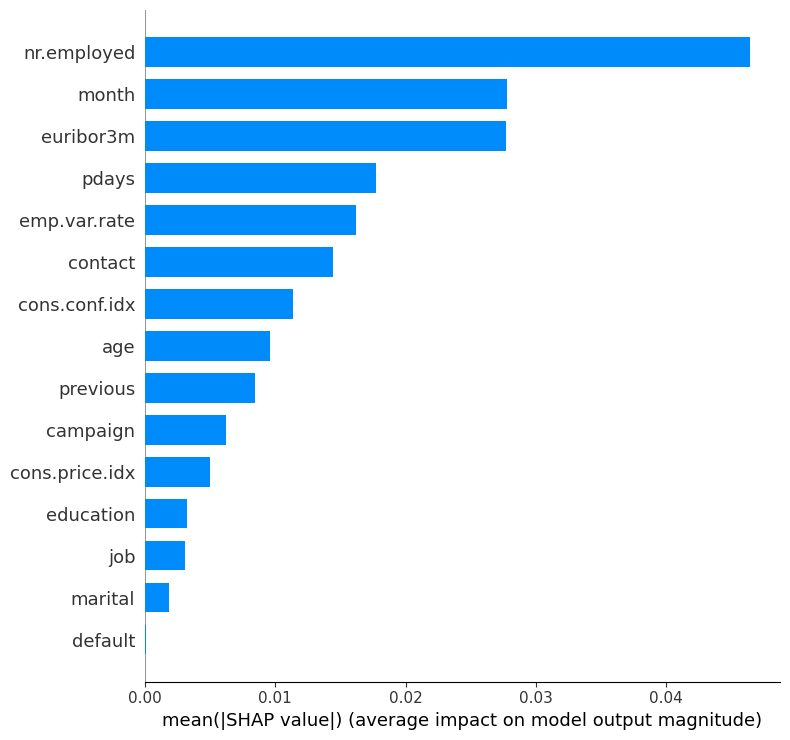

In [42]:
shap.summary_plot(shap_vals, X_val, plot_type="bar")

## 4.1.4 Unión 3 métodos

In [43]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
0,age,23.778381,23.778381,2.323075e+15,4.819303
8,euribor3m,19.815450,43.593831,8.186258e+15,13.917837
1,campaign,10.209961,53.803792,1.442018e+14,3.111057
9,job,9.375203,63.178995,5.439774e+14,1.523198
6,education,7.387637,70.566632,1.517140e+14,1.634749
12,nr.employed,5.862724,76.429356,7.337745e+15,23.325691
13,pdays,5.704896,82.134251,1.193430e+15,8.905990
10,marital,3.992622,86.126873,1.501984e+14,0.935584
14,previous,2.906619,89.033492,4.403007e+15,4.257850
2,cons.conf.idx,2.894364,91.927857,8.894837e+14,5.712870


In [44]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
0,age,23.778381,23.778381,2.323075e+15,4.819303
8,euribor3m,19.815450,43.593831,8.186258e+15,13.917837
1,campaign,10.209961,53.803792,1.442018e+14,3.111057
9,job,9.375203,63.178995,5.439774e+14,1.523198
6,education,7.387637,70.566632,1.517140e+14,1.634749
12,nr.employed,5.862724,76.429356,7.337745e+15,23.325691
13,pdays,5.704896,82.134251,1.193430e+15,8.905990
14,previous,2.906619,89.033492,4.403007e+15,4.257850
2,cons.conf.idx,2.894364,91.927857,8.894837e+14,5.712870
7,emp.var.rate,2.345923,94.273779,1.425631e+16,8.133144


In [45]:
features = df_filt['feature']
features

0                age
8          euribor3m
1           campaign
9                job
6          education
12       nr.employed
13             pdays
14          previous
2      cons.conf.idx
7       emp.var.rate
3     cons.price.idx
11             month
Name: feature, dtype: object

In [46]:
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_train_imp[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

age                1.066104
euribor3m         79.407967
campaign           1.034648
job                1.022503
education          1.093745
nr.employed       34.339416
pdays              1.614230
previous           1.814349
cons.conf.idx      2.718188
emp.var.rate      35.052506
cons.price.idx     7.060240
month              1.541757
dtype: float64

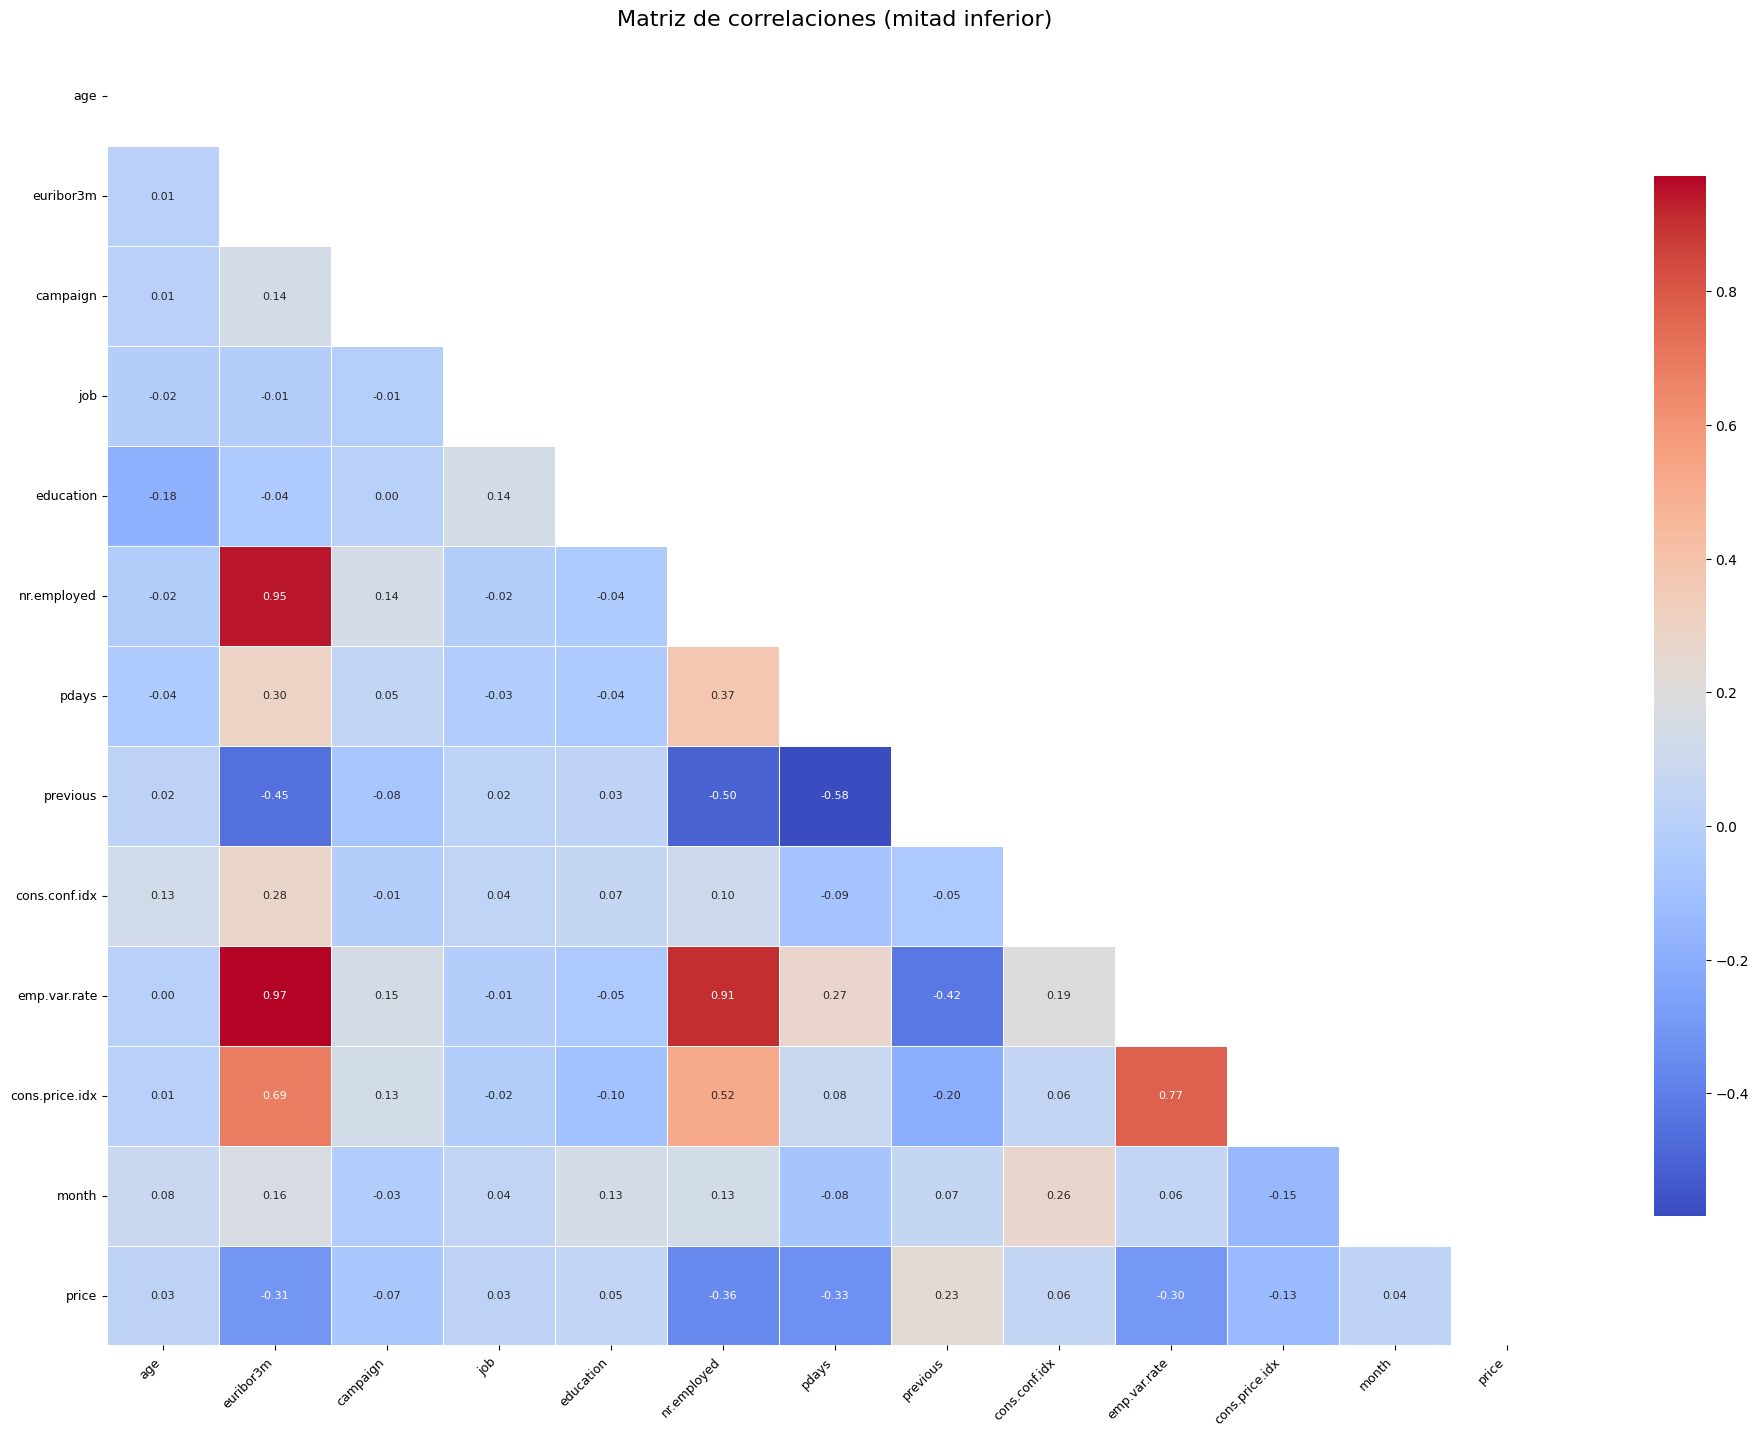

In [47]:
X_copy = X_train_imp[features].copy()
X_copy['price'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

In [48]:
# Versión 1: Realizar cross_validation con todas las características que son candidatas
cv_results1 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train_imp[features], y_train, cv=3, scoring='neg_mean_absolute_percentage_error')

In [49]:
cv_results1.mean()*-1

np.float64(393342666442743.94)

In [50]:
cv_results2 = cross_val_score(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    X_train_imp[features].drop([
        'nr.employed',         # correlación 0.91 con emp.var.rate
        'emp.var.rate',        # correlación 0.91 con nr.employed
        'cons.price.idx',      # correlación 0.77 con emp.var.rate
        'pdays'                # correlación 0.50 con previous
    ], axis=1),
    y_train,
    cv=3,
    scoring='neg_mean_absolute_percentage_error'
)


In [51]:
cv_results2.mean()*-1

np.float64(402998174547426.8)

# 5.1 Modelado

In [52]:
# Selecciona la caracteristicas con las que hemos determinado que vamos a proseguir el análisis
X_train_sel = X_train_imp[features]
X_test_sel = X_test[features]

In [53]:
X_train_sel.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32950.0,40.017420,10.435842,17.000,32.000,38.000,47.000,98.000
euribor3m,32950.0,3.622698,1.733735,0.634,1.344,4.857,4.961,5.045
campaign,32950.0,2.572959,2.778138,1.000,1.000,2.000,3.000,56.000
job,32950.0,3.624917,3.555414,-1.000,0.000,2.000,7.000,10.000
education,32950.0,4.142822,1.657508,0.000,3.000,4.000,6.000,6.000
nr.employed,32950.0,5167.094049,72.354625,4963.600,5099.100,5191.000,5228.100,5228.100
pdays,32950.0,962.745341,186.248245,0.000,999.000,999.000,999.000,999.000
previous,32950.0,0.172989,0.492992,0.000,0.000,0.000,0.000,7.000
cons.conf.idx,32950.0,-40.514574,4.622683,-50.800,-42.700,-41.800,-36.400,-26.900
emp.var.rate,32950.0,0.083105,1.570011,-3.400,-1.800,1.100,1.400,1.400


In [54]:
model = LogisticRegression(random_state=42, max_iter=1000)


In [55]:
model.fit(X_train_sel, y_train)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# 5.2 Escalamos los datos

In [56]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# use esto por que al ejecutar el modelo salian muchos warnings que no me dejaban ver con claridad los resultados, asi que los oculte


In [57]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=2000,  # puedes subirlo a 2000 o más
        random_state=42
    )
)
model.fit(X_train_sel, y_train)



,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [58]:
# Configuración de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Modelo A: sin escalado
model_a = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
results_a = cross_validate(model_a, X_train_sel, y_train, cv=cv, scoring=scoring)

# Modelo B: con escalado
model_b = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
results_b = cross_validate(model_b, X_train_sel, y_train, cv=cv, scoring=scoring)

# Mostrar resultados comparativos
def resumen(resultados, nombre):
    return pd.DataFrame({
        'Modelo': nombre,
        'Accuracy': resultados['test_accuracy'].mean(),
        'Precision': resultados['test_precision'].mean(),
        'Recall': resultados['test_recall'].mean(),
        'F1': resultados['test_f1'].mean()
    }, index=[0])

df_comparativa = pd.concat([
    resumen(results_a, 'Sin escalado'),
    resumen(results_b, 'Con escalado')
], ignore_index=True)

print(df_comparativa.round(4))

         Modelo  Accuracy  Precision  Recall      F1
0  Sin escalado    0.8999     0.7047  0.1897  0.2989
1  Con escalado    0.8999     0.7065  0.1892  0.2983


Los resultados muestran que el escalado de variables no ha tenido un impacto significativo en las métricas del modelo. La precisión y el F1 apenas varían, mientras que la exactitud se mantiene constante. Aunque el rendimiento es similar, aplicar escalado mejora la estabilidad del entrenamiento al evitar advertencias de convergencia.